In [27]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [1]:
import json

import pandas as pd
import geopandas as gpd
import rioxarray as riox

from pyproj import Transformer
from shapely.geometry import mapping

In [2]:
points = pd.read_csv('test-data/APPMA_test_subset.csv')
points.head()

,x,y
0,1.338752e+06,-3.860481e+06
1,1.164170e+06,-3.923904e+06
2,1.259190e+06,-4.078028e+06
3,1.088017e+06,-3.216140e+06
4,1.923990e+06,-4.192711e+06


In [38]:
(
    riox.open_rasterio('test-data/Impervious_Surface_NOAA_Satellite_2010/Impervious_Surface_NOAA_Satellite_2010/data_provided/impsa_2010_20210519.tif')
    .sel(band=1)
    .nbytes
) / 1024**2

629.7026643753052

In [39]:
(
    riox.open_rasterio('test-data/Impervious_Surface_NOAA_Satellite_2010/Impervious_Surface_NOAA_Satellite_2010/data_provided/impsa_2010_20210519.tif')
    .sel(band=1)
)

<xarray.DataArray (y: 22031, x: 29971)>
[660291101 values with dtype=uint8]
Coordinates:
    band         int64 1
  * x            (x) float64 96.82 96.82 96.82 96.82 ... 159.2 159.3 159.3 159.3
  * y            (y) float64 -9.222 -9.224 -9.226 ... -55.11 -55.12 -55.12
    spatial_ref  int64 0
Attributes:
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  3.543583083713092
    STATISTICS_MAXIMUM:      100
    STATISTICS_MEAN:         0.081010541781926
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       1.8824407251526
    _FillValue:              250.0
    scale_factor:            1.0
    add_offset:              0.0

In [3]:
raster = (
    riox.open_rasterio('test-data/Impervious_Surface_NOAA_Satellite_2010/Impervious_Surface_NOAA_Satellite_2010/data_provided/impsa_2010_20210519.tif', mask_and_scale=True)
    .sel(band=1)
)

In [30]:
raster

<xarray.DataArray (y: 22031, x: 29971)>
[660291101 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 96.82 96.82 96.82 96.82 ... 159.2 159.3 159.3 159.3
  * y            (y) float64 -9.222 -9.224 -9.226 ... -55.11 -55.12 -55.12
    spatial_ref  int64 0
Attributes:
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  3.543583083713092
    STATISTICS_MAXIMUM:      100
    STATISTICS_MEAN:         0.081010541781926
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       1.8824407251526

In [33]:
raster.x.values[raster.x.values > 150]

array([150.00080167, 150.002885  , 150.00496833, ..., 159.25078687,
       159.2528702 , 159.25495353])

In [35]:
%%memit
raster.sel(x=raster.x.values[raster.x.values > 150], y=raster.y.values[raster.y.values < -9]).mean().item()

peak memory: 1862.05 MiB, increment: 1027.28 MiB


In [36]:
raster.sel(x=raster.x.values[raster.x.values > 150], y=raster.y.values[raster.y.values < -9]).mean().item()

0.5564061999320984

In [4]:
raster.rio.crs

CRS.from_epsg(4283)

In [5]:
transformer = Transformer.from_crs("EPSG:3577", raster.rio.crs, always_xy=True)

In [6]:
lat_long_points = (
    pd.Series(points.apply(lambda row: transformer.transform(row['x'], row['y']), axis=1), name='lat_long_tuple').to_frame()
    .assign(
        x=lambda col: col['lat_long_tuple'].apply(lambda xx: xx[0]),
        y=lambda col: col['lat_long_tuple'].apply(lambda xx: xx[1])
    )
)

In [7]:
lat_long_points['extracted'] = lat_long_points[['x', 'y']].apply(lambda row: raster.sel(x=row['x'], y=row['y'], method="nearest").values, axis=1)

In [8]:
lat_long_points.head()

,lat_long_tuple,x,y,extracted
0,"(146.6897558575884, -34.6523707513246)",146.689756,-34.652371,0.0
1,"(144.8577049948836, -35.38806689394188)",144.857705,-35.388067,0.0
2,"(146.08603136242695, -36.67940370746854)",146.086031,-36.679404,0.0
3,"(143.33014417830566, -29.148710955228086)",143.330144,-29.148711,0.0
4,"(153.62179911184072, -36.86883390213634)",153.621799,-36.868834,nan


In [9]:
lat_long_points.sample(20)

,lat_long_tuple,x,y,extracted
3,"(143.33014417830566, -29.148710955228086)",143.330144,-29.148711,0.0
88,"(150.59567999187453, -30.054188950642246)",150.595680,-30.054189,0.0
60,"(152.83843050096817, -30.892687110569344)",152.838431,-30.892687,0.0
87,"(147.96996523987673, -29.023528011480447)",147.969965,-29.023528,0.0
65,"(154.58710800692612, -33.67716402918433)",154.587108,-33.677164,nan
80,"(143.70115664074214, -37.86120434638178)",143.701157,-37.861204,0.0
7,"(149.6804381902303, -31.597563573796847)",149.680438,-31.597564,0.0
23,"(145.01841135076913, -29.75400241276482)",145.018411,-29.754002,0.0
62,"(149.09299116257841, -31.412058450931188)",149.092991,-31.412058,0.0
43,"(144.44769198568815, -35.298014019783494)",144.447692,-35.298014,0.0


In [10]:
lat_long_points.sample(20)

,lat_long_tuple,x,y,extracted
56,"(147.81044929351336, -30.74781817165037)",147.810449,-30.747818,0.0
34,"(152.61591369898753, -33.31608846352227)",152.615914,-33.316088,nan
97,"(146.63899617130008, -33.92510953117563)",146.638996,-33.925110,0.0
54,"(147.54172197553797, -31.824019671882496)",147.541722,-31.824020,0.0
27,"(153.04304098503, -33.521053457639404)",153.043041,-33.521053,nan
4,"(153.62179911184072, -36.86883390213634)",153.621799,-36.868834,nan
71,"(141.7769679627315, -31.224906838865827)",141.776968,-31.224907,0.0
90,"(153.13479455367215, -31.357390928875752)",153.134795,-31.357391,nan
86,"(153.5711948118514, -35.677757431307164)",153.571195,-35.677757,nan
48,"(141.42287227724222, -30.10912362932307)",141.422872,-30.109124,5.0


In [11]:
lat_long_points['extracted'].describe()

count     100
unique     25
top       0.0
freq       76
Name: extracted, dtype: object

In [12]:
lat_long_points['extracted'].dtype

dtype('O')

In [13]:
from shapely.geometry import Point

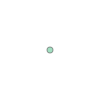

In [14]:
p = Point((152.8471830906596, -35.45607186517823))
p

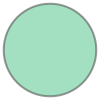

In [15]:
p.buffer(10)

In [16]:
repr(p.buffer(10))

'<shapely.geometry.polygon.Polygon object at 0x7f1a9f019f40>'

In [17]:
vars(p.buffer(10))

{'_is_empty': True, '__geom__': None, '__p__': None, '_ndim': 2}

In [18]:
type(p.buffer(10))

shapely.geometry.polygon.Polygon

In [19]:
lat_long_points['points'] = lat_long_points['lat_long_tuple'].apply(Point)
lat_long_points.head()

,lat_long_tuple,x,y,extracted,points
0,"(146.6897558575884, -34.6523707513246)",146.689756,-34.652371,0.0,POINT (146.6897558575884 -34.6523707513246)
1,"(144.8577049948836, -35.38806689394188)",144.857705,-35.388067,0.0,POINT (144.8577049948836 -35.38806689394188)
2,"(146.08603136242695, -36.67940370746854)",146.086031,-36.679404,0.0,POINT (146.086031362427 -36.67940370746854)
3,"(143.33014417830566, -29.148710955228086)",143.330144,-29.148711,0.0,POINT (143.3301441783057 -29.14871095522809)
4,"(153.62179911184072, -36.86883390213634)",153.621799,-36.868834,nan,POINT (153.6217991118407 -36.86883390213634)


In [20]:
lat_long_points['points_buffer_10'] = lat_long_points['points'].apply(lambda x: x.buffer(10))

In [21]:
lat_long_points['points_buffer_10_map'] = lat_long_points['points_buffer_10'].apply(lambda x: [mapping(x)])

In [22]:
lat_long_points.head()

,lat_long_tuple,x,y,extracted,points,points_buffer_10,points_buffer_10_map
0,"(146.6897558575884, -34.6523707513246)",146.689756,-34.652371,0.0,POINT (146.6897558575884 -34.6523707513246),"POLYGON ((156.6897558575884 -34.6523707513246,...","[{'type': 'Polygon', 'coordinates': (((156.689..."
1,"(144.8577049948836, -35.38806689394188)",144.857705,-35.388067,0.0,POINT (144.8577049948836 -35.38806689394188),POLYGON ((154.8577049948836 -35.38806689394188...,"[{'type': 'Polygon', 'coordinates': (((154.857..."
2,"(146.08603136242695, -36.67940370746854)",146.086031,-36.679404,0.0,POINT (146.086031362427 -36.67940370746854),"POLYGON ((156.086031362427 -36.67940370746854,...","[{'type': 'Polygon', 'coordinates': (((156.086..."
3,"(143.33014417830566, -29.148710955228086)",143.330144,-29.148711,0.0,POINT (143.3301441783057 -29.14871095522809),POLYGON ((153.3301441783057 -29.14871095522809...,"[{'type': 'Polygon', 'coordinates': (((153.330..."
4,"(153.62179911184072, -36.86883390213634)",153.621799,-36.868834,nan,POINT (153.6217991118407 -36.86883390213634),POLYGON ((163.6217991118407 -36.86883390213634...,"[{'type': 'Polygon', 'coordinates': (((163.621..."


In [23]:
lat_long_points['points_buffer_10_map_nolist'] = lat_long_points['points_buffer_10'].apply(mapping)

In [24]:
lat_long_points.shape

(100, 8)

In [25]:
lat_long_points.head()

,lat_long_tuple,x,y,extracted,points,points_buffer_10,points_buffer_10_map,points_buffer_10_map_nolist
0,"(146.6897558575884, -34.6523707513246)",146.689756,-34.652371,0.0,POINT (146.6897558575884 -34.6523707513246),"POLYGON ((156.6897558575884 -34.6523707513246,...","[{'type': 'Polygon', 'coordinates': (((156.689...","{'type': 'Polygon', 'coordinates': (((156.6897..."
1,"(144.8577049948836, -35.38806689394188)",144.857705,-35.388067,0.0,POINT (144.8577049948836 -35.38806689394188),POLYGON ((154.8577049948836 -35.38806689394188...,"[{'type': 'Polygon', 'coordinates': (((154.857...","{'type': 'Polygon', 'coordinates': (((154.8577..."
2,"(146.08603136242695, -36.67940370746854)",146.086031,-36.679404,0.0,POINT (146.086031362427 -36.67940370746854),"POLYGON ((156.086031362427 -36.67940370746854,...","[{'type': 'Polygon', 'coordinates': (((156.086...","{'type': 'Polygon', 'coordinates': (((156.0860..."
3,"(143.33014417830566, -29.148710955228086)",143.330144,-29.148711,0.0,POINT (143.3301441783057 -29.14871095522809),POLYGON ((153.3301441783057 -29.14871095522809...,"[{'type': 'Polygon', 'coordinates': (((153.330...","{'type': 'Polygon', 'coordinates': (((153.3301..."
4,"(153.62179911184072, -36.86883390213634)",153.621799,-36.868834,nan,POINT (153.6217991118407 -36.86883390213634),POLYGON ((163.6217991118407 -36.86883390213634...,"[{'type': 'Polygon', 'coordinates': (((163.621...","{'type': 'Polygon', 'coordinates': (((163.6217..."


In [43]:
clip_geom = lat_long_points['points_buffer_10_map_nolist'].values.tolist()

In [44]:
%%memit
raster.rio.clip(clip_geom)

peak memory: 8404.79 MiB, increment: 7556.41 MiB


In [46]:
clipping_output = raster.rio.clip(clip_geom)
clipping_output

<xarray.DataArray (y: 14138, x: 13498)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 -18.41 -18.41 -18.41 ... -47.86 -47.86 -47.86
  * x            (x) float64 131.1 131.1 131.1 131.1 ... 159.2 159.3 159.3 159.3
    band         int64 1
    spatial_ref  int64 0
Attributes:
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  3.543583083713092
    STATISTICS_MAXIMUM:      100
    STATISTICS_MEAN:         0.081010541781926
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       1.8824407251526

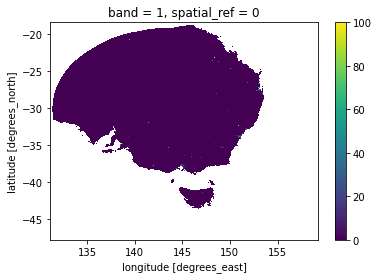

In [59]:
clipping_output.plot()

In [57]:
%%memit
tmp_r = clipping_output.rio.clip_box(*lat_long_points['points_buffer_10'][0].bounds)
tmp_r.rio.clip(lat_long_points['points_buffer_10_map'][0]).mean().item()

peak memory: 4308.98 MiB, increment: 2002.32 MiB


In [58]:
%%memit
clipping_output.rio.clip_box(*lat_long_points['points_buffer_10'][0].bounds).mean().item()

peak memory: 3534.43 MiB, increment: 876.12 MiB


In [51]:
raster.nbytes / 1024**2

2518.8106575012207

In [50]:
clipping_output.nbytes / 1024**2

727.9766998291016

In [47]:
clipping_output.groupby(['y','x']).mean()

TypeError: `group` must be an xarray.DataArray or the name of an xarray variable or dimension.Received ['y', 'x'] instead.

In [49]:
raster.sel(x=lat_long_points['x'][0], y=lat_long_points['y'][0], method="nearest").values

array(0., dtype=float32)

In [25]:
%%memit
raster.rio.clip(lat_long_points['points_buffer_10_map'][0]).mean()

peak memory: 8390.22 MiB, increment: 8200.43 MiB


In [28]:
%%memit
raster.rio.clip(lat_long_points['points_buffer_10_map'][0], from_disk=True)#.mean().item()

peak memory: 8388.72 MiB, increment: 8200.27 MiB


In [26]:
raster.rio.clip(lat_long_points['points_buffer_10_map'][0]).mean().item()#.values[0]

0.2017309069633484

In [30]:
lat_long_points['points_buffer_10'][0].bounds

(136.6897558575884, -44.6523707513246, 156.6897558575884, -24.652370751324597)

In [34]:
%%memit
raster.rio.clip_box(*lat_long_points['points_buffer_10'][0].bounds)

peak memory: 813.62 MiB, increment: 0.02 MiB


In [29]:
%%memit
tmp = raster.rio.clip_box(*lat_long_points['points_buffer_10'][0].bounds)
tmp.rio.clip(lat_long_points['points_buffer_10_map'][0], from_disk=True)

peak memory: 2463.77 MiB, increment: 1630.24 MiB


In [38]:
bounded_box_raster = raster.rio.clip_box(*lat_long_points['points_buffer_10'][0].bounds)
bounded_box_raster

<xarray.DataArray (y: 9601, x: 9601)>
[92179201 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 136.7 136.7 136.7 136.7 ... 156.7 156.7 156.7 156.7
  * y            (y) float64 -24.65 -24.66 -24.66 ... -44.65 -44.65 -44.65
    spatial_ref  int64 0
Attributes:
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  3.543583083713092
    STATISTICS_MAXIMUM:      100
    STATISTICS_MEAN:         0.081010541781926
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       1.8824407251526

In [39]:
%%memit
bounded_box_raster.rio.clip(lat_long_points['points_buffer_10_map'][0])

peak memory: 2478.16 MiB, increment: 1630.50 MiB


In [27]:
%%memit
%%timeit
lat_long_points['extracted_at_buffer'] = lat_long_points['points_buffer_10_map'].apply(
    lambda x: raster.rio.clip(x).mean().item()
)

KeyboardInterrupt: 

In [ ]:
polygon = lat_long_points['points_buffer'][0]

In [ ]:
mapping(polygon)

In [ ]:
json.dumps(
        mapping(polygon),
        indent=4
    )

In [ ]:
lat_long_points['extracted_at_buffer'] = lat_long_points['points_buffer_10'].apply(lambda x: raster.rio.clip()